# Data preparation

In [8]:
# Based on the codes in the Eduardo's code as well as the code in the Spotipy documentation https://spotipy.readthedocs.io/en/2.22.1/

# import dependencies
import spotipy as sp
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Authorisation
from config import CLIENT_ID
from config import CLIENT_SECRET

# Initialize the Spotify client with client credentials flow
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = sp.Spotify(client_credentials_manager=client_credentials_manager)



In [16]:
# Changed a couple of the links, so we have consistent data. 
# We had top TRACKS playlist for a couple of years (len = 50) but top HITS for the other years (len = 100), 
# so I've made it consistent
Years = {"2017": "https://open.spotify.com/playlist/37i9dQZF1DWTE7dVUebpUW",
        "2018": "https://open.spotify.com/playlist/37i9dQZF1DXe2bobNYDtW8",
        "2019": "https://open.spotify.com/playlist/37i9dQZF1DWVRSukIED0e9",
        "2020": "https://open.spotify.com/playlist/2fmTTbBkXi8pewbUvG3CeZ",
        "2021": "https://open.spotify.com/playlist/5GhQiRkGuqzpWZSE7OU4Se",
        "2022": "https://open.spotify.com/playlist/56r5qRUv3jSxADdmBkhcz7"}

# set empty lists to add data to
track_features = []
track_id = []
track_name = []
track_popularity = []
artist_name = []
artist_id = []
artist_genre = []

# loop through years to request data we need for each year
for year in Years:
    playlist_URI = Years[year]
    
    # apend gave me a list of lists, so using extend instead    
    # get tracks for this year
    track_id_this_year = [x["track"]["id"] for x in sp.playlist_tracks(playlist_URI)["items"]]
   
    # get track features
    track_features.extend(sp.audio_features(track_id_this_year))    
    
    #get the rest of tracks info
    track_id.extend(track_id_this_year)
    track_name.extend ([x["track"]["name"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    track_popularity.extend ([x["track"]["popularity"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    
    # get artist info
    artist_name.extend([x["track"]["artists"][0]["name"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    artist_id.extend([x["track"]["artists"][0]["id"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    
    # get artist uri so we can get genre
    artist_uri = [x["track"]["artists"][0]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
    artist_genre.extend([sp.artist(uri)["genres"] for uri in artist_uri])
    

In [17]:
# join all the information in a dataframe

# first the track info
years = ['2017', '2018', '2019', '2020', '2021', '2022']
year_index = np.repeat(years,100)

track_info = pd.DataFrame({"Year": year_index,
                           "id" : track_id,
                           "artist id" : artist_id,
                           "track name" : track_name,
                           "artist name" : artist_name,
                           "artist genre": artist_genre,
                           "track popularity" : track_popularity})

# then the track features
track_features_df = pd.DataFrame(track_features)

# and now merge the two
complete_df = pd.merge(track_info, track_features_df, on = "id", how = "inner")

# the merged df has 44 duplicates, so getting rid of them here. We end up with a df with len = 600 (100 songs for each year)
complete_df = complete_df.drop_duplicates(["id", "Year"])

# save output
#complete_df.to_csv('output_data/spotipy_data.csv')


In [32]:
# Group the data by 'Year' to prepare for extraction
grouped_by_year = complete_df.groupby('Year')

# Display the first 10 artists and songs for each year
for year, group in grouped_by_year:
    top_10_year = group.head(10)
    print(f"\nTop 10 in {year}:\n")
    print(top_10_year[['artist name', 'track name']])



Top 10 in 2017:

         artist name                               track name
0         Ed Sheeran                             Shape of You
1    Imagine Dragons                                 Believer
2         Luis Fonsi                                Despacito
3  Machine Gun Kelly         Bad Things (with Camila Cabello)
4       Clean Bandit  Rockabye (feat. Sean Paul & Anne-Marie)
5     Camila Cabello                Havana (feat. Young Thug)
6    Imagine Dragons                                  Thunder
7           Maroon 5  Don't Wanna Know (feat. Kendrick Lamar)
8   The Chainsmokers                 Something Just Like This
9         Ed Sheeran                                  Perfect

Top 10 in 2018:

          artist name                                         track name
28     Kendrick Lamar                                LOVE. FEAT. ZACARI.
53             G-Eazy                              Him & I (with Halsey)
73   Hailee Steinfeld  Let Me Go (with Alesso, Florida Georgia 

In [57]:
#get top 5 most active artists per year
# Group data by Year and artist name then count occurrences and sort the values
artist_activity = complete_df.groupby(['Year', 'artist name']).size().reset_index(name='song_count').sort_values(by=['Year', 'song_count'], ascending=[True, False])

# Get the top 5 active artists for each year
five_most_successful_artists_by_year = artist_activity.groupby('Year').head(5)

print(five_most_successful_artists_by_year)


     Year      artist name  song_count
20   2017       Ed Sheeran           5
34   2017   Kendrick Lamar           4
27   2017  Imagine Dragons           3
5    2017           Avicii           2
9    2017       Bruno Mars           2
96   2018            Drake           5
123  2018       Marshmello           4
87   2018          Cardi B           3
124  2018            Migos           3
131  2018      Post Malone           3
211  2019      Post Malone           5
159  2019    Ariana Grande           4
165  2019    Billie Eilish           4
193  2019    Lewis Capaldi           4
194  2019        Lil Nas X           3
232  2020    Billie Eilish           4
242  2020         Dua Lipa           4
256  2020    Justin Bieber           4
226  2020    Ariana Grande           3
229  2020        BLACKPINK           3
297  2021    Ariana Grande           5
310  2021         Doja Cat           5
301  2021    Billie Eilish           4
323  2021    Justin Bieber           4
340  2021   Olivia Rodrig

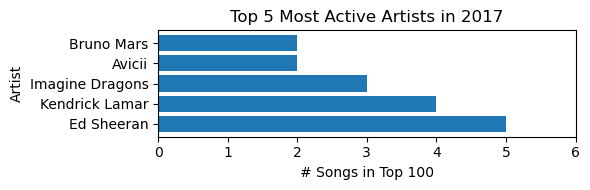

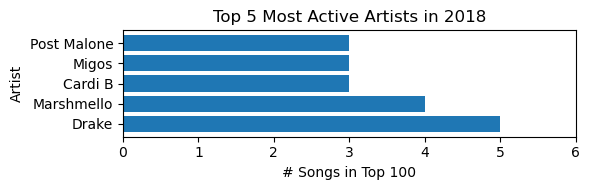

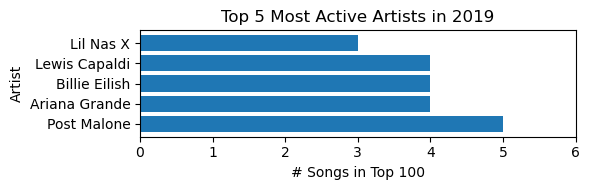

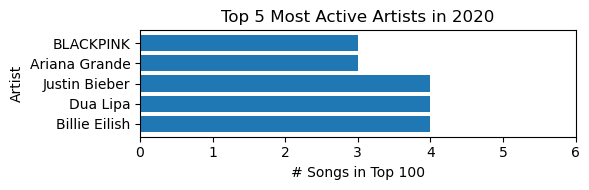

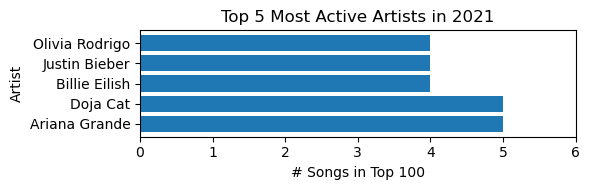

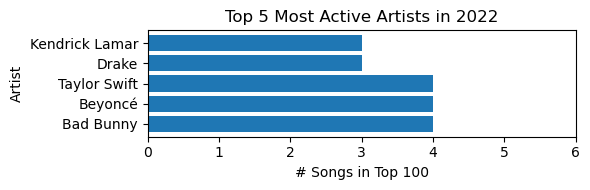

In [20]:
# Group the data by 'Year' and 'artist name' to prepare for plotting
grouped_data = five_most_successful_artists_by_year.groupby('Year')

# Create separate plots for each year
for name, group in grouped_data:
    plt.figure(figsize=(6, 2))
    plt.barh(group['artist name'], group['artist_count'])
    plt.xlabel('# Songs in Top 100')
    plt.ylabel('Artist')
    plt.title(f'Top 5 Most Active Artists in {name}')
    plt.xlim(0, 6)
    plt.tight_layout()
    plt.show()

In [59]:
# Convert duration_ms to minutes rounded to 2 decimal places in a new column 'duration_minutes'
complete_df['duration_minutes'] = complete_df['duration_ms'] / 60000

# Calculate the average track duration in minutes for each of the top 5 artists
avg_duration_per_artist = top_artists_data.groupby(['Year', 'artist name'])['duration_minutes'].mean().reset_index()

for index, row in avg_duration_per_artist.iterrows():
    avg_duration_rounded = round(row['duration_minutes'], 2)
    print(f"Year: {row['Year']} | Artist: {row['artist name']} | Average Track Duration (minutes): {avg_duration_rounded}")


Year: 2017 | Artist: Avicii | Average Track Duration (minutes): 3.03
Year: 2017 | Artist: Billie Eilish | Average Track Duration (minutes): 3.02
Year: 2017 | Artist: Bruno Mars | Average Track Duration (minutes): 3.61
Year: 2017 | Artist: Cardi B | Average Track Duration (minutes): 3.73
Year: 2017 | Artist: Drake | Average Track Duration (minutes): 4.25
Year: 2017 | Artist: Dua Lipa | Average Track Duration (minutes): 3.49
Year: 2017 | Artist: Ed Sheeran | Average Track Duration (minutes): 3.79
Year: 2017 | Artist: Imagine Dragons | Average Track Duration (minutes): 3.29
Year: 2017 | Artist: Kendrick Lamar | Average Track Duration (minutes): 3.27
Year: 2017 | Artist: Migos | Average Track Duration (minutes): 5.72
Year: 2017 | Artist: Post Malone | Average Track Duration (minutes): 3.7
Year: 2017 | Artist: Taylor Swift | Average Track Duration (minutes): 3.5
Year: 2018 | Artist: Ariana Grande | Average Track Duration (minutes): 3.36
Year: 2018 | Artist: Billie Eilish | Average Track Dur

   Year  duration_minutes
0  2017          3.696559
1  2018          3.494120
2  2019          3.299158
3  2020          3.296727
4  2021          3.277226
5  2022          3.307454


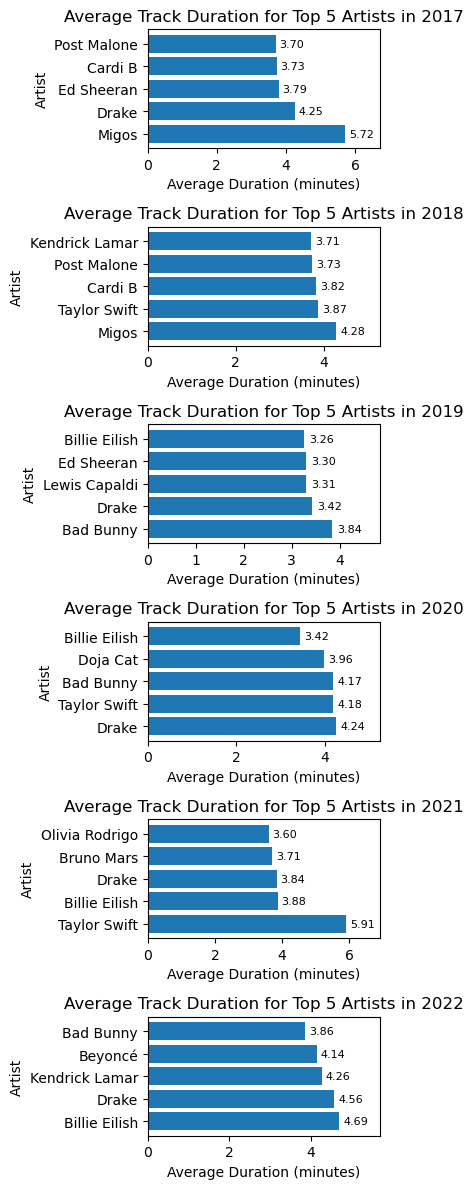

In [52]:
# Calculate the average track duration for each year
avg_duration_per_year = complete_df.groupby('Year')['duration_minutes'].mean().reset_index()
print(avg_duration_per_year)

# Create an empty list to store filtered top 5 artists data
top_5_artists_data = []

for year in years:
    # Filter data for the current year
    year_data = avg_duration_per_artist[avg_duration_per_artist['Year'] == year]
    
    # Sort the data by duration_minutes column and get the top 5 artists for each year
    top_5_artists_year = year_data.nlargest(5, 'duration_minutes')
    
    # Append the top 5 artists for the current year to the list
    top_5_artists_data.append(top_5_artists_year)

# Create a figure and axis for subplots
fig, axs = plt.subplots(nrows=len(years), figsize=(4, 2 * len(years)))

for i, year_data in enumerate(top_5_artists_data):
    year = years[i]
    artists = year_data['artist name']
    avg_durations = year_data['duration_minutes']
    
    # Create a bar plot for the current year
    ax = axs[i]
    ax.barh(artists, avg_durations)
    ax.set_title(f'Average Track Duration for Top 5 Artists in {year}')
    ax.set_xlabel('Average Duration (minutes)')
    ax.set_ylabel('Artist')
    ax.set_xlim(0, max(avg_durations) + 1)
    
    # Show average duration values on each bar
    for j, duration in enumerate(avg_durations):
        ax.text(duration + 0.1, j, f'{duration:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()